## Sentiment Analysis

In [1]:
import os
import json
import zipfile
import tempfile
from glob import glob
import pandas as pd
import sys

# ================= CONFIG =================
ZIP_FILES = [
    ("walmart_reviews_asc.zip", "round_2_low_to_high")
]

EXCEL_ROUND_1 = "/content/walmart_reviews_flat.csv"

OUTPUT_DIR = "combined_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

ALL_PRODUCTS = []
ALL_REVIEWS = []

# ================= ROUND 1 : EXCEL (ID-FIRST) =================
df_excel = pd.read_csv(EXCEL_ROUND_1)

# ---- HARD FAIL IF product_id MISSING ----
if "product_id" not in df_excel.columns:
    sys.exit("❌ Excel must contain 'product_id' column. Pipeline stopped.")

missing_ids = df_excel[df_excel["product_id"].isna()]
if not missing_ids.empty:
    print("❌ Missing product_id in Excel for rows:\n")
    print(missing_ids[["product_name"]].drop_duplicates())
    sys.exit("🔥 Fix Excel product_id values.")

for _, row in df_excel.iterrows():
    ALL_REVIEWS.append({
        "product_id": row["product_id"],
        "product_name": row["product_name"],
        "review_position": None,
        "review_title": row["review_title"],
        "review_text": row["review_text"],
        "rating": row["rating"],
        "positive_feedback": None,
        "negative_feedback": None,
        "review_date": row["date"],
        "user_nickname": row["user"],
        "verified_purchaser": bool(row["verified"]),
        "source_zip": "walmart_reviews.zip",
        "source_label": "round_1_relevance",
        "source_file": EXCEL_ROUND_1
    })

# ================= ROUND 2 : ZIP =================
for zip_path, scrape_label in ZIP_FILES:
    if not os.path.exists(zip_path):
        continue

    with tempfile.TemporaryDirectory() as tmpdir:
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall(tmpdir)

        for filepath in glob(os.path.join(tmpdir, "**", "*.raw.json"), recursive=True):
            with open(filepath, "r", encoding="utf-8") as f:
                data = json.load(f)

            search_params = data.get("search_parameters")
            product_id = None
            if isinstance(search_params, dict):
                product_id = search_params.get("product_id")
            elif isinstance(search_params, list) and search_params:
                product_id = search_params[0].get("product_id")

            product_name = data.get("product", {}).get("name")

            product_data = {
                "product_id": product_id,
                "product_name": product_name,
                "overall_rating_source": data.get("overall_rating"),
                "total_review_count_source": data.get("total_count"),
                "source_zip": os.path.basename(zip_path),
                "source_label": scrape_label,
                "source_file": os.path.basename(filepath)
            }

            for r in data.get("ratings", []):
                stars = r.get("stars")
                if stars is not None:
                    product_data[f"rating_{stars}_count_source"] = r.get("count")

            ALL_PRODUCTS.append(product_data)

            for rev in data.get("reviews", []) or []:
                ALL_REVIEWS.append({
                    "product_id": product_id,
                    "product_name": product_name,
                    "review_position": rev.get("position"),
                    "review_title": rev.get("title"),
                    "review_text": rev.get("text"),
                    "rating": rev.get("rating"),
                    "positive_feedback": rev.get("positive_feedback"),
                    "negative_feedback": rev.get("negative_feedback"),
                    "review_date": rev.get("review_submission_time"),
                    "user_nickname": rev.get("user_nickname"),
                    "verified_purchaser": "VerifiedPurchaser" in (rev.get("customer_type") or []),
                    "source_zip": os.path.basename(zip_path),
                    "source_label": scrape_label,
                    "source_file": os.path.basename(filepath)
                })

# ================= DATAFRAMES =================
df_products_raw = pd.DataFrame(ALL_PRODUCTS)
df_reviews_raw = pd.DataFrame(ALL_REVIEWS)

df_products = df_products_raw.drop_duplicates()
df_reviews = df_reviews_raw.drop_duplicates()

# ================= AGGREGATION =================
rating_counts = (
    df_reviews
    .groupby(["product_id", "rating"])
    .size()
    .unstack(fill_value=0)
    .add_prefix("rating_count_")
    .reset_index()
)

product_agg = (
    df_reviews
    .groupby("product_id")
    .agg(
        total_reviews_collected=("review_text", "count"),
        avg_rating=("rating", "mean"),
        median_rating=("rating", "median")
    )
    .reset_index()
)

product_summary = (
    df_products
    .drop_duplicates("product_id")
    .merge(product_agg, on="product_id", how="outer")
    .merge(rating_counts, on="product_id", how="left")
)

# ================= SAVE OUTPUTS =================
df_products_raw.to_csv(os.path.join(OUTPUT_DIR, "raw_products_all.csv"), index=False)
df_reviews_raw.to_csv(os.path.join(OUTPUT_DIR, "raw_reviews_all.csv"), index=False)
product_summary.to_csv(os.path.join(OUTPUT_DIR, "combined_products_summary.csv"), index=False)
df_reviews.to_csv(os.path.join(OUTPUT_DIR, "combined_product_reviews.csv"), index=False)

print("✅ DONE. ID-first pipeline completed successfully.")


✅ DONE. ID-first pipeline completed successfully.


In [2]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.4 MB/s eta 0:00:00


In [3]:
# Sentiment + keyword pipeline (filter reviews from 2022 onward, product-wise rating counts,
# VADER sentiment scoring, and product-wise top keywords)

import re
from collections import Counter
import pandas as pd
import numpy as np

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# ---------- NLTK downloads (will no-op if already present) ----------
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# ---------- Your products mapping (as provided) ----------
products = {
    "Lipton Green Tea Bags 100 Ct": "174779977",
    "Lipton Diet Green Tea Citrus 12-Pack": "11960997",
    "Knorr Veg Soup Mix 1.4 oz": "10291773",
    "Hellmann's Mayo 20 oz": "43887962",
    "Magnum Caramel Ice Cream Bars 3 Ct": "17283520",
    "Pond's Cold Cream 6.1 oz": "10804630",
    "Tresemme Curl Mousse 10.5 oz": "10295557",
    "Tresemme Leave-in Conditioner 6.1 oz": "940310308",
    "AXE Apollo Body Wash 32 oz": "728579794",
    "Vaseline Body Oil 13 oz": "10898766",
    "Pepsodent Toothpaste 5.5 oz": "191756851",
    "Dove Deep Moisture Body Wash": "10804694",
    "Dove Intense Repair Shampoo": "9019603356"
}

def parse_mixed_date(s):
    if pd.isna(s):
        return pd.NaT
    s = str(s).strip()
    # dash-separated → assume DD-MM-YYYY
    if '-' in s:
        return pd.to_datetime(s, format='%d-%m-%Y', errors='coerce')
    # slash-separated → assume MM/DD/YYYY
    if '/' in s:
        return pd.to_datetime(s, format='%m/%d/%Y', errors='coerce')
    return pd.to_datetime(s, errors='coerce')



# ---------- 1) Prepare DataFrame and apply date filter ----------
reviews_df = pd.read_csv('./combined_output/combined_product_reviews.csv')
reviews_df['review_date'] = reviews_df['review_date'].apply(parse_mixed_date)
filtered = reviews_df.loc[reviews_df['review_date'] >= pd.to_datetime('2022-01-01')].copy()

# ---------- 2) Normalize product label: map product_id -> readable product name where possible ----------
# Create reverse map from id (int) to product name
reverse_products = {int(v): k for k, v in products.items()}

# create a 'product' column to use consistently: prefer mapped name via product_id, else product_name
filtered['product'] = filtered['product_id'].map(reverse_products)
# fallback to original product_name if mapping not found
filtered['product'] = filtered['product'].fillna(filtered['product_name']).astype(str)

# ---------- 3) Product-wise rating counts (for filtered period) ----------
# This gives a table with products as rows and rating values as columns (counts)
rating_counts = (
    filtered
    .groupby(['product', 'rating'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)
# Example: rating_counts.loc["Lipton Green Tea Bags 100 Ct", 5] gives # of 5-star reviews for that product

# ---------- 4) VADER sentiment scoring ----------
analyzer = SentimentIntensityAnalyzer()

# Ensure review_text is a string and not null
filtered['review_text'] = filtered['review_text'].fillna('').astype(str)

# compute VADER scores
def vader_scores(text):
    return analyzer.polarity_scores(text)

vader_df = filtered['review_text'].apply(vader_scores).apply(pd.Series)
# columns: 'neg','neu','pos','compound'
filtered = pd.concat([filtered, vader_df], axis=1)

# label by common thresholds
def vader_label(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

filtered['vader_label'] = filtered['compound'].apply(vader_label)

# ---------- 5) Product-level sentiment & rating summary ----------
# sentiment distribution per product
sentiment_counts = filtered.groupby(['product', 'vader_label']).size().unstack(fill_value=0)

# mean compound per product + average rating + total reviews
product_stats = filtered.groupby('product').agg(
    total_reviews = ('review_text', 'size'),
    avg_rating = ('rating', 'mean'),
    median_rating = ('rating', 'median'),
    mean_compound = ('compound', 'mean')
).sort_values('total_reviews', ascending=False)

# Combine rating_counts, product_stats and sentiment_counts into a single summary DataFrame
summary = product_stats.join(rating_counts, how='left').join(sentiment_counts, how='left').fillna(0)

# ---------- 6) Keyword extraction (simple frequency-based) ----------
# Preprocessing setup
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
token_pattern = re.compile(r"[a-zA-Z']{3,}")  # tokens with letters and length >=3

def preprocess_for_keywords(text, extra_stop=None):
    """Lowercase, keep alpha-ish tokens, remove stopwords, lemmatize."""
    if not text:
        return []
    text = text.lower()
    tokens = word_tokenize(text)
    clean = []
    for t in tokens:
        if not token_pattern.fullmatch(t):
            continue

        # Lemmatize first
        t_lem = lemmatizer.lemmatize(t)

        # Then filter by stopwords
        if t_lem in stop_words:
            continue
        if extra_stop and t_lem in extra_stop:
            continue
        if len(t_lem) >= 3:
            clean.append(t_lem)
    return clean

def top_keywords_for_product(df_prod, prod, top_n=20):
    """Return top_n keywords (Counter) for the product's review_text."""
    # Build extra_stopwords from product name tokens to avoid product-name leakage
    prod_tokens = set([t.lower() for t in re.findall(r"[a-zA-Z']{2,}", prod)])
    # collect tokens across reviews
    all_tokens = []
    for text in df_prod['review_text'].fillna(''):
        toks = preprocess_for_keywords(text, extra_stop=prod_tokens)
        all_tokens.extend(toks)
    return Counter(all_tokens).most_common(top_n)


# build dict of top keywords per product
top_keywords = {}
for prod, grp in filtered.groupby('product'):
    top_keywords[prod] = top_keywords_for_product(grp, prod, top_n=20)


# Optional: top keywords split by sentiment per product
top_keywords_by_sentiment = {}
for prod, grp in filtered.groupby('product'):
    by_sent = {}
    for sentiment in ['positive', 'neutral', 'negative']:
        grp_sent = grp[grp['vader_label'] == sentiment]
        by_sent[sentiment] = top_keywords_for_product(grp_sent, prod, top_n=15)
    top_keywords_by_sentiment[prod] = by_sent

# ---------- 7) (Optional) Save outputs or print summaries ----------
# Save summary tables to CSV for inspection, or print small snippets.
summary.to_csv('product_summary.csv')                # combined stats + rating buckets + sentiment counts
rating_counts.to_csv('rating_counts_by_product.csv')
filtered.to_csv('filtered_reviews_with_vader.csv', index=False)

# Print quick console summaries
print("=== Product summary (first 10 rows) ===")
print(summary.head(10).round(3))

print("\n=== Top keywords (example for first 5 products) ===")
for i, (prod, kw) in enumerate(top_keywords.items()):
    print(f"\nProduct: {prod}")
    print(kw[:10])  # show top 10 tokens
    if i >= 4:
        break


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


=== Product summary (first 10 rows) ===
                                      total_reviews  avg_rating  \
product                                                           
Dove Deep Moisture Body Wash                    312       2.949   
Lipton Diet Green Tea Citrus 12-Pack            288       2.913   
AXE Apollo Body Wash 32 oz                      285       4.144   
Hellmann's Mayo 20 oz                           282       2.447   
Tresemme Curl Mousse 10.5 oz                    280       3.786   
Knorr Veg Soup Mix 1.4 oz                       276       2.283   
Dove Intense Repair Shampoo                     273       4.223   
Vaseline Body Oil 13 oz                         247       3.955   
Tresemme Leave-in Conditioner 6.1 oz            230       3.565   
Pond's Cold Cream 6.1 oz                        198       4.338   

                                      median_rating  mean_compound    1   2  \
product                                                                     

In [4]:
reviews_df[reviews_df["product_id"]==191756851]

product_id                                       product_name  \
1970   191756851                         Pepsodent Toothpaste 55 oz   
1971   191756851                         Pepsodent Toothpaste 55 oz   
1972   191756851                         Pepsodent Toothpaste 55 oz   
1973   191756851                         Pepsodent Toothpaste 55 oz   
1974   191756851                         Pepsodent Toothpaste 55 oz   
...          ...                                                ...   
3830   191756851  Pepsodent Complete Care Original Toothpaste 5.5oz   
3831   191756851  Pepsodent Complete Care Original Toothpaste 5.5oz   
3832   191756851  Pepsodent Complete Care Original Toothpaste 5.5oz   
3833   191756851  Pepsodent Complete Care Original Toothpaste 5.5oz   
3834   191756851  Pepsodent Complete Care Original Toothpaste 5.5oz   

      review_position                  review_title  \
1970              NaN                           NaN   
1971              NaN                           NaN   
1972              NaN                           NaN   
1973              NaN          Pepsodent Toothpaste   
1974              NaN                           NaN   
...               ...                           ...   
3830             36.0                  Just buy it.   
3831             37.0  Whiter smile for less money.   
3832             38.0                   Good flavor   
3833             39.0                           NaN   
3834             40.0        My favorite toothpaste   

                                            review_text  rating  \
1970  i ordered the toothpaste with other items, it ...       1   
1971  Love the taste. I have been using this brand f...       5   
1972  the "item description" read it was a "multi-pa...       1   
1973  I ordered a tube of Pepsodent Toothpaste onlin...       4   
1974     cool minty and really does help restore enamel       5   
...                                                 ...     ...   
3830                          Love the taste and price.       5   
3831  I have been using this product for years. It p...       5   
3832  This isn't overly minty and leaves my teeth fe...       5   
3833  its been around for years, like the taste and ...       5   
3834  This is my favorite toothpaste, very mild mint...       5   

      positive_feedback  negative_feedback review_date user_nickname  \
1970                NaN                NaN  2025-12-07        andrea   
1971                NaN                NaN  2025-07-15        Barbie   
1972                NaN                NaN  2024-08-27          Nick   
1973                NaN                NaN  2025-07-04      Josephus   
1974                NaN                NaN  2025-04-23          lisa   
...                 ...                ...         ...           ...   
3830                0.0                0.0  2021-09-11       Charles   
3831                0.0                0.0  2020-11-17         susan   
3832                0.0                0.0  2020-10-14      Tippi247   
3833                0.0                0.0  2025-08-03         Marcy   
3834                0.0                0.0  2021-07-21        Venita   

      verified_purchaser               source_zip         source_label  \
1970                True      walmart_reviews.zip    round_1_relevance   
1971                True      walmart_reviews.zip    round_1_relevance   
1972                True      walmart_reviews.zip    round_1_relevance   
1973                True      walmart_reviews.zip    round_1_relevance   
1974                True      walmart_reviews.zip    round_1_relevance   
...                  ...                      ...                  ...   
3830                True  walmart_reviews_asc.zip  round_2_low_to_high   
3831                True  walmart_reviews_asc.zip  round_2_low_to_high   
3832                True  walmart_reviews_asc.zip  round_2_low_to_high   
3833                True  walmart_reviews_asc.zip  round_2_low_to_high   
3834    

In [5]:
summary.index.to_list()

['Dove Deep Moisture Body Wash',
 'Lipton Diet Green Tea Citrus 12-Pack',
 'AXE Apollo Body Wash 32 oz',
 "Hellmann's Mayo 20 oz",
 'Tresemme Curl Mousse 10.5 oz',
 'Knorr Veg Soup Mix 1.4 oz',
 'Dove Intense Repair Shampoo',
 'Vaseline Body Oil 13 oz',
 'Tresemme Leave-in Conditioner 6.1 oz',
 "Pond's Cold Cream 6.1 oz",
 'Lipton Green Tea Bags 100 Ct',
 'Magnum Caramel Ice Cream Bars 3 Ct',
 'Pepsodent Toothpaste 5.5 oz']

In [6]:
summary

total_reviews  avg_rating  \
product                                                           
Dove Deep Moisture Body Wash                    312    2.948718   
Lipton Diet Green Tea Citrus 12-Pack            288    2.913194   
AXE Apollo Body Wash 32 oz                      285    4.143860   
Hellmann's Mayo 20 oz                           282    2.446809   
Tresemme Curl Mousse 10.5 oz                    280    3.785714   
Knorr Veg Soup Mix 1.4 oz                       276    2.282609   
Dove Intense Repair Shampoo                     273    4.223443   
Vaseline Body Oil 13 oz                         247    3.955466   
Tresemme Leave-in Conditioner 6.1 oz            230    3.565217   
Pond's Cold Cream 6.1 oz                        198    4.338384   
Lipton Green Tea Bags 100 Ct                    129    4.240310   
Magnum Caramel Ice Cream Bars 3 Ct              114    2.859649   
Pepsodent Toothpaste 5.5 oz                      32    3.937500   

                                      median_rating  mean_compound    1   2  \
product                                                                       
Dove Deep Moisture Body Wash                    2.0       0.208598  136  22   
Lipton Diet Green Tea Citrus 12-Pack            2.0       0.223694  131  20   
AXE Apollo Body Wash 32 oz                      5.0       0.483471   26  11   
Hellmann's Mayo 20 oz                           1.0       0.233764  166  11   
Tresemme Curl Mousse 10.5 oz                    4.0       0.416036   48   9   
Knorr Veg Soup Mix 1.4 oz                       1.0       0.110184  162  17   
Dove Intense Repair Shampoo                     5.0       0.556697   22  10   
Vaseline Body Oil 13 oz                         5.0       0.329402   41  22   
Tresemme Leave-in Conditioner 6.1 oz            5.0       0.367702   57  15   
Pond's Cold Cream 6.1 oz                        5.0       0.452484   30   0   
Lipton Green Tea Bags 100 Ct                    5.0       0.780267    1   2   
Magnum Caramel Ice Cream Bars 3 Ct              3.0       0.261474   48   6   
Pepsodent Toothpaste 5.5 oz                     5.0       0.322828    7   0   

                                       3   4    5  negative  neutral  positive  
product                                                                         
Dove Deep Moisture Body Wash           8  14  132        88       45       179  
Lipton Diet Green Tea Citrus 12-Pack   4   9  124        65       68       155  
AXE Apollo Body Wash 32 oz            22  63  163        31       24       230  
Hellmann's Mayo 20 oz                  7   9   89        72       57       153  
Tresemme Curl Mousse 10.5 oz          29  63  131        40       45       195  
Knorr Veg Soup Mix 1.4 oz             17  17   63       110       29       137  
Dove Intense Repair Shampoo           16  62  163        24       25       224  
Vaseline Body Oil 13 oz                8  12  164        39       49       159  
Tresemme Leave-in Conditioner 6.1 oz  17  23  118        45       27       158  
Pond's Cold Cream 6.1 oz               2   7  159        19       25       154  
Lipton Green Tea Bags 100 Ct          35  18   73         2        2       125  
Magnum Caramel Ice Cream Bars 3 Ct    11  12   37        35       11        68  
Pepsodent Toothpaste 5.5 oz            2   2   21         3        9        20

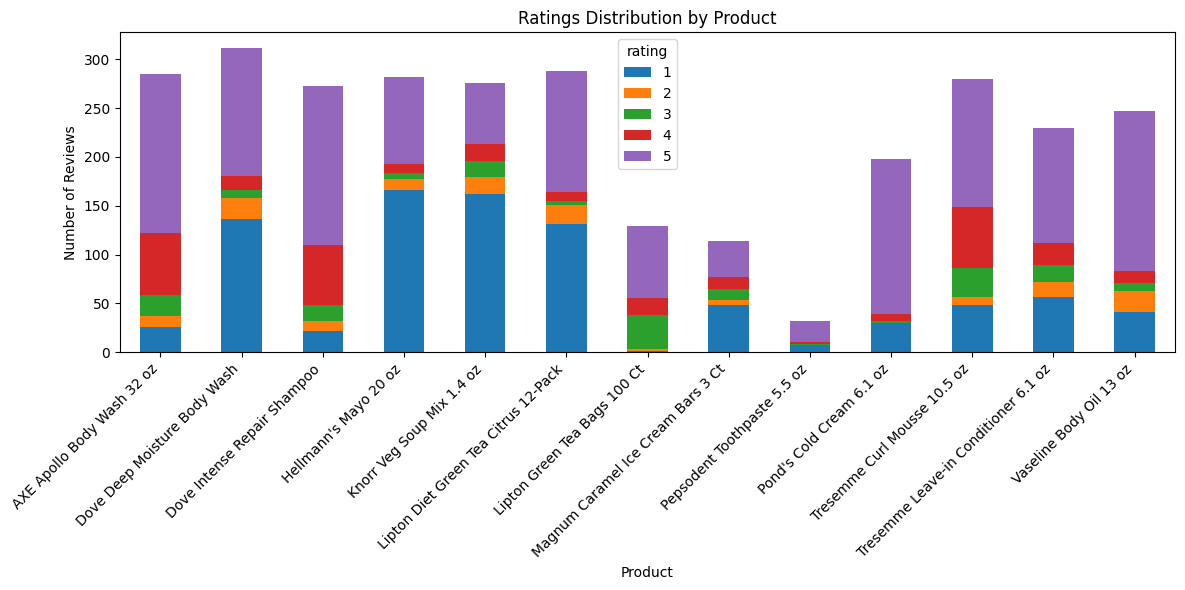

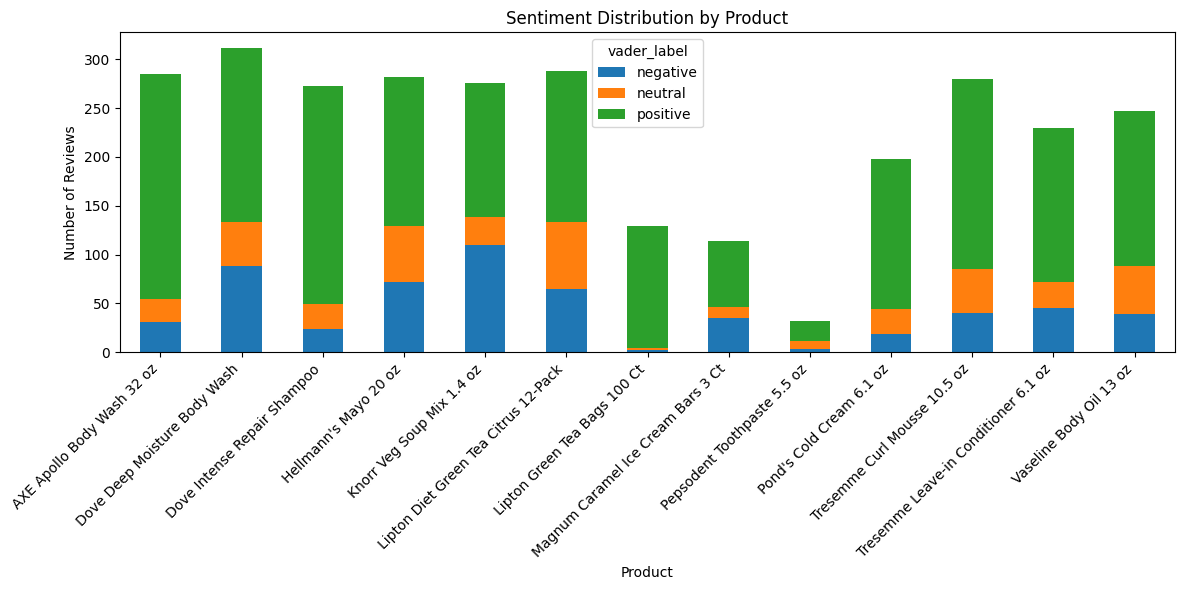

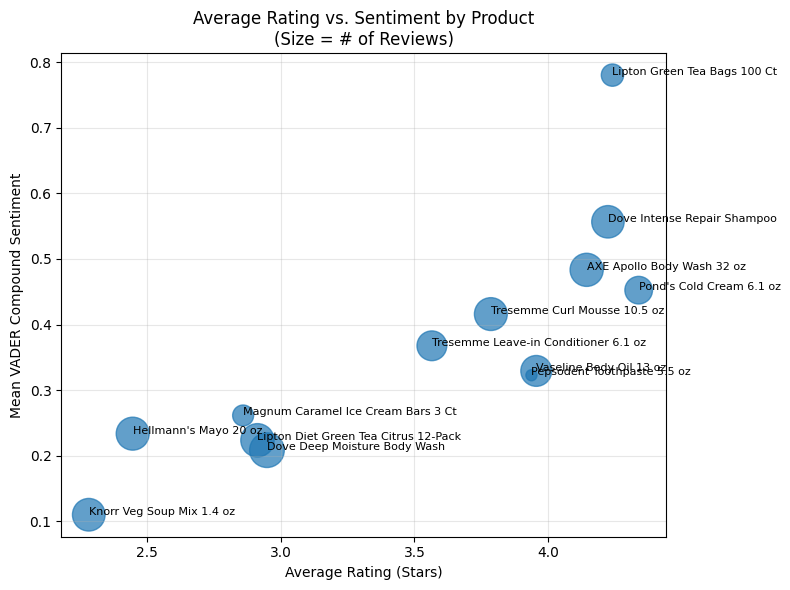

In [7]:
import matplotlib.pyplot as plt

# ---------- 1) Ratings distribution per product ----------
rating_counts.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title="Ratings Distribution by Product"
)
plt.ylabel("Number of Reviews")
plt.xlabel("Product")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------- 2) Sentiment distribution per product ----------
sentiment_counts.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title="Sentiment Distribution by Product"
)
plt.ylabel("Number of Reviews")
plt.xlabel("Product")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------- 3) Average rating vs. Mean sentiment ----------
plt.figure(figsize=(8, 6))
plt.scatter(summary['avg_rating'], summary['mean_compound'], s=summary['total_reviews']*2, alpha=0.7)
for i, txt in enumerate(summary.index):
    plt.annotate(txt, (summary['avg_rating'].iloc[i], summary['mean_compound'].iloc[i]), fontsize=8)
plt.xlabel("Average Rating (Stars)")
plt.ylabel("Mean VADER Compound Sentiment")
plt.title("Average Rating vs. Sentiment by Product\n(Size = # of Reviews)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- 4) Top keywords per product ----------
# def plot_top_keywords(product_name, top_n=10):
#     if product_name not in top_keywords:
#         print(f"No keywords for {product_name}")
#         return
#     kws = dict(top_keywords[product_name][:top_n])
#     plt.figure(figsize=(8, 5))
#     plt.barh(list(kws.keys()), list(kws.values()))
#     plt.title(f"Top {top_n} Keywords for {product_name}")
#     plt.xlabel("Frequency")
#     plt.gca().invert_yaxis()  # highest at top
#     plt.tight_layout()
#     plt.show()

# # Example: plot keywords for first product in summary
# example_product = summary.index[0]
# plot_top_keywords(example_product, top_n=10)


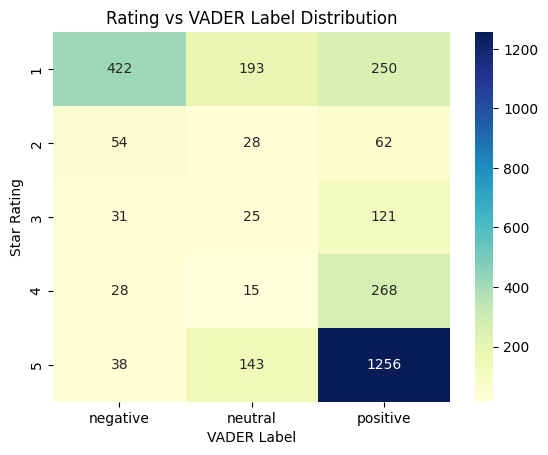

/tmp/ipython-input-70751724.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', y='compound', data=filtered, palette='Set2')


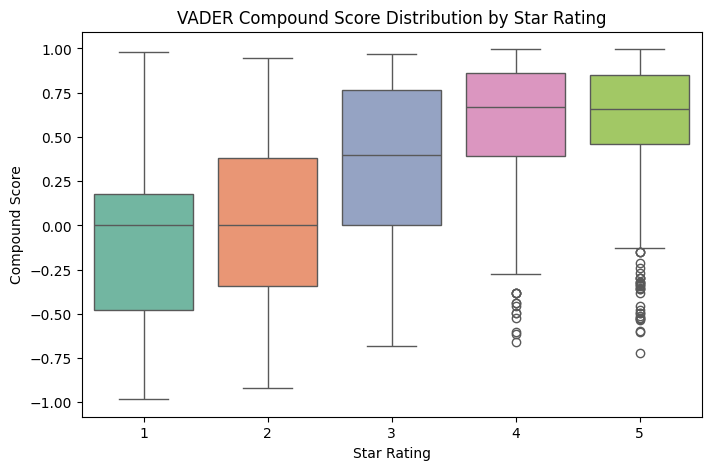

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter

# Load preprocessed DataFrame
filtered = pd.read_csv('filtered_reviews_with_vader.csv')
summary = pd.read_csv('product_summary.csv', index_col=0)

# Ensure consistent product_category mapping
category_map = {
    'Dove Deep Moisture Body Wash': 'Personal Care',
    'Dove Intense Repair Shampoo': 'Personal Care',
    'AXE Apollo Body Wash 32 oz': 'Personal Care',
    "Pond's Cold Cream 6.1 oz": 'Personal Care',
    'Tresemme Curl Mousse 10.5 oz': 'Hair Care',
    'Tresemme Leave-in Conditioner 6.1 oz': 'Hair Care',
    'Lipton Green Tea Bags 100 Ct': 'Foods',
    'Lipton Diet Green Tea Citrus 12-Pack': 'Food & Beverage',
    'Knorr Veg Soup Mix 1.4 oz': 'Food & Beverage',
    "Hellmann's Mayo 20 oz": 'Food & Beverage',
    'Magnum Caramel Ice Cream Bars 3 Ct': 'Food & Beverage',
    'Vaseline Body Oil 13 oz': 'Personal Care',
    'Pepsodent Toothpaste 5.5 oz': 'Personal Care'
}
filtered['product_category'] = filtered['product'].map(category_map)

# 1. Rating–Sentiment Divergence Heatmap
pivot = filtered.pivot_table(index='rating', columns='vader_label',
                             values='review_text', aggfunc='count').fillna(0)
sns.heatmap(pivot, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Rating vs VADER Label Distribution')
plt.ylabel('Star Rating')
plt.xlabel('VADER Label')
plt.show()

# 2. Compound Score Distribution Box Plots by Rating
plt.figure(figsize=(8,5))
sns.boxplot(x='rating', y='compound', data=filtered, palette='Set2')
plt.title('VADER Compound Score Distribution by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Compound Score')
plt.show()




In [9]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 37.8 MB/s eta 0:00:00


In [10]:
import gensim
from gensim import corpora
from gensim.models import LdaModel

# Tokenize preprocessed review_text
filtered = filtered[filtered['review_text'].notna()]
tokenized_texts = filtered['review_text'].map(preprocess_for_keywords).tolist()

# Build dictionary and corpus
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Train LDA
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=5,       # you can experiment with this number
                     random_state=42,
                     passes=10,
                     alpha='auto')

# Show topics
topics = lda_model.print_topics(num_words=10)
for topic_no, topic in topics:
    print(f"Topic {topic_no}: {topic}")


Topic 0: 0.037*"tea" + 0.020*"green" + 0.014*"n't" + 0.014*"taste" + 0.013*"like" + 0.011*"diet" + 0.011*"one" + 0.010*"drink" + 0.010*"lipton" + 0.009*"flavor"
Topic 1: 0.034*"product" + 0.024*"n't" + 0.018*"item" + 0.011*"order" + 0.010*"receive" + 0.009*"received" + 0.009*"got" + 0.008*"delivered" + 0.008*"walmart" + 0.008*"delivery"
Topic 2: 0.024*"n't" + 0.014*"cream" + 0.014*"product" + 0.013*"use" + 0.013*"like" + 0.012*"change" + 0.012*"bar" + 0.010*"ice" + 0.009*"caramel" + 0.009*"mayo"
Topic 3: 0.036*"dip" + 0.028*"recipe" + 0.022*"package" + 0.021*"soup" + 0.016*"make" + 0.015*"mix" + 0.013*"vegetable" + 0.012*"back" + 0.010*"n't" + 0.009*"spinach"
Topic 4: 0.030*"hair" + 0.024*"product" + 0.022*"smell" + 0.017*"good" + 0.016*"great" + 0.014*"n't" + 0.013*"skin" + 0.013*"body" + 0.013*"love" + 0.012*"like"


In [11]:
# Get topic distribution per document
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# Assign dominant topic per review
dominant_topics = [max(dist, key=lambda x: x[1])[0] if dist else -1 for dist in topic_distributions]

# Add to DataFrame
filtered['dominant_topic'] = dominant_topics

# Example: topic distribution per product
topic_summary = (
    filtered.groupby(['product', 'dominant_topic'])
    .size()
    .unstack(fill_value=0)
)

print(topic_summary.head())


dominant_topic                 0   1   2    3    4
product                                           
AXE Apollo Body Wash 32 oz    12  23   8   11  231
Dove Deep Moisture Body Wash  12  27  15   13  245
Dove Intense Repair Shampoo   16  25   9    2  221
Hellmann's Mayo 20 oz         53  41  76   42   67
Knorr Veg Soup Mix 1.4 oz     13  11   3  225   18


In [12]:
topic_summary_full = filtered.groupby(['product', 'dominant_topic']).size().unstack(fill_value=0)
print(topic_summary_full)


dominant_topic                          0   1   2    3    4
product                                                    
AXE Apollo Body Wash 32 oz             12  23   8   11  231
Dove Deep Moisture Body Wash           12  27  15   13  245
Dove Intense Repair Shampoo            16  25   9    2  221
Hellmann's Mayo 20 oz                  53  41  76   42   67
Knorr Veg Soup Mix 1.4 oz              13  11   3  225   18
Lipton Diet Green Tea Citrus 12-Pack  173  42  16   18   38
Lipton Green Tea Bags 100 Ct          116   1   1    1   10
Magnum Caramel Ice Cream Bars 3 Ct     11   4  54   32   13
Pepsodent Toothpaste 5.5 oz             5  14   0    2   11
Pond's Cold Cream 6.1 oz               10   7  44    8  129
Tresemme Curl Mousse 10.5 oz            8  15  22    7  228
Tresemme Leave-in Conditioner 6.1 oz    6  12   3   12  197
Vaseline Body Oil 13 oz                47  46  26   17  109


In [13]:
# Cross-tab of dominant_topic vs vader_label
topic_sentiment = filtered.groupby(['dominant_topic', 'vader_label']).size().unstack(fill_value=0)

# Also compute proportions per topic
topic_sentiment_pct = topic_sentiment.div(topic_sentiment.sum(axis=1), axis=0)

print(topic_sentiment)
print(topic_sentiment_pct.round(3))  # Rounded percentages


vader_label     negative  neutral  positive
dominant_topic                             
0                     71       74       337
1                     85      109        74
2                     74       32       171
3                    163       53       174
4                    180      136      1201
vader_label     negative  neutral  positive
dominant_topic                             
0                  0.147    0.154     0.699
1                  0.317    0.407     0.276
2                  0.267    0.116     0.617
3                  0.418    0.136     0.446
4                  0.119    0.090     0.792


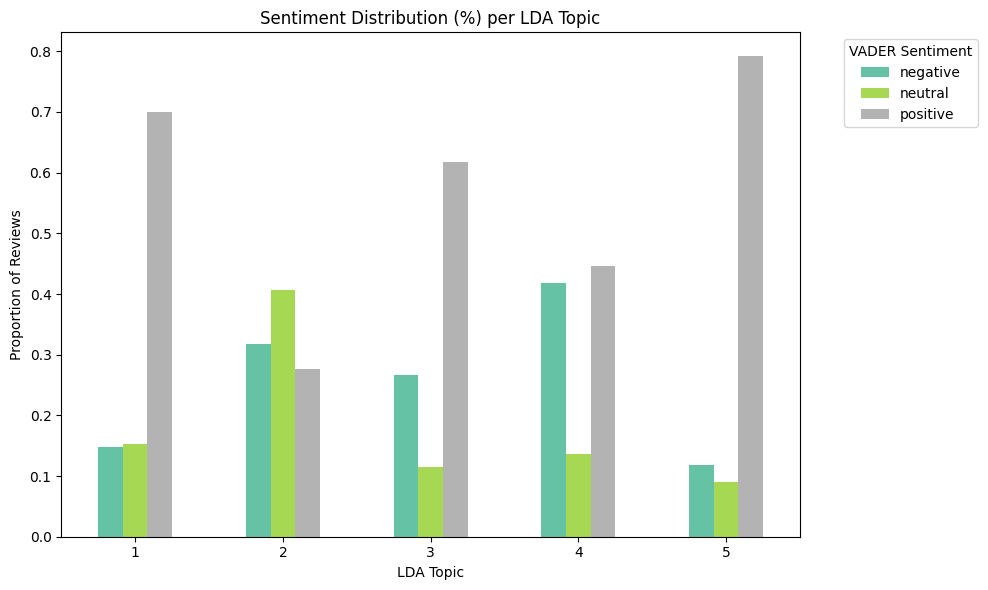

In [14]:
# Shift the index for display purposes
topic_sentiment_pct.index = topic_sentiment_pct.index + 1

# Plot
topic_sentiment_pct.plot(kind='bar', figsize=(10,6), colormap='Set2')
plt.title('Sentiment Distribution (%) per LDA Topic')
plt.ylabel('Proportion of Reviews')
plt.xlabel('LDA Topic')
plt.xticks(rotation=0)
plt.legend(title='VADER Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Forcasting model

In [15]:
# Requirements: pandas, numpy, scikit-learn
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt

# --- helper metrics
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid division by zero: use small epsilon or mask zeros
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (np.maximum(np.abs(y_true), eps)))) * 100

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# --- configure segments / column names (adjust if needed)
segments = ["Personal Care", "Foods", "Home Care", "Others"]  # target column names
gt_suffix = "_GT"
macro_cols = ["CPI", "CSI", "FEI"]

#read filr
df = pd.read_csv("demand_forecast_data.csv")


In [16]:
gt_cols = [
    "Personal Care_GT",
    "Foods_GT",
    "Home Care_GT",
    "Others_GT"
]

gt_segment = df[["Quarter"] + gt_cols].rename(columns={"Quarter": "quarter"})
gt_segment.head()


quarter  Personal Care_GT  Foods_GT  Home Care_GT  Others_GT
0  2019Q1          6.133333  6.111111      7.444444  52.333333
1  2019Q2          5.933333  6.222222      7.777778  36.000000
2  2019Q3          6.066667  5.777778      7.666667  24.666667
3  2019Q4          6.200000  5.444444     17.000000  21.666667
4  2020Q1          5.466667  5.555556      7.888889  30.000000

In [17]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

def prepare_gt_features(gt_segment, final_df):
    # --- Ensure final_df uses "Quarter" as index ---
    if "Quarter" in final_df.columns:
        final_df = final_df.set_index("Quarter")

    # --- Ensure gt_segment uses "quarter" as index ---
    if "quarter" in gt_segment.columns:
        gt_quarters = gt_segment.set_index("quarter")
    else:
        raise KeyError("gt_segment must contain 'quarter' column")

    # --- Align quarters ---
    common_quarters = gt_quarters.index.intersection(final_df.index)
    gt_quarters = gt_quarters.loc[common_quarters]

    # --- Standardize values ---
    scaler = StandardScaler()
    gt_features = pd.DataFrame(
        scaler.fit_transform(gt_quarters),
        index=gt_quarters.index,
        columns=gt_quarters.columns
    )

    # --- Rename for clarity ---
    gt_features.columns = [col.replace("_GT", "_GoogleTrends") for col in gt_features.columns]

    return gt_features

# ✅ Usage
gt_features = prepare_gt_features(gt_segment, df)
final_df_enhanced = df.set_index("Quarter").join(gt_features, how="inner")


In [18]:
final_df_enhanced

Personal Care  Foods  Home Care  Others  Personal Care YoY %  \
Quarter                                                                 
2019Q1            4440   1783       3146     409             0.748809   
2019Q2            4349   1703       3079     359             0.764597   
2019Q3            4579   1728       3147     387            11.955990   
2019Q4            4432   1916       3502     351             8.203125   
2020Q1            4626   1950       3464     324             4.189189   
2020Q2            4580   1847       3370     308             5.311566   
2020Q3            4448   1865       3456     334            -2.860887   
2020Q4            3834   1788       3350     239           -13.492780   
2021Q1            4043   2958       3392     338           -12.602681   
2021Q2            4550   3379       3318     436            -0.655022   
2021Q3            4868   3356       3409     548             9.442446   
2021Q4            4577   3511       3838     507            19.379238   
2022Q1            4585   3319       3797     493            13.405887   
2022Q2            5026   3622       3838     560            10.461538   
2022Q3            5213   3466       4192     568             7.087099   
2022Q4            4743   3698       4743     583             3.626830   
2023Q1            5406   3627       4930     661            17.906216   
2023Q2            5595   3755       5142     652            11.321130   
2023Q3            5764   3700       5514     619            10.569730   
2023Q4            5257   3794       5637     527            10.837023   
2024Q1            5668   3797       5421     610             4.846467   
2024Q2            5873   3851       5308     591             4.968722   
2024Q3            5782   3733       5444     608             0.312283   
2024Q4            5125   3910       5709     466            -2.510938   
2025Q1            5667   3850       5673     517            -0.017643   
2025Q2            5832   3803       5731     560            -0.698110   

         Foods YoY %  Home Care YoY %  Others YoY %  \
Quarter                                               
2019Q1     -0.112045         0.000000    174.496644   
2019Q2     -0.058685        -0.032468    167.910448   
2019Q3      9.923664        14.812112    106.951872   
2019Q4     10.432277        12.894907    114.024390   
2020Q1      9.366237        10.108074    -20.782396   
2020Q2      8.455666         9.451120    -14.206128   
2020Q3      7.928241         9.818875    -13.695090   
2020Q4     -6.680585        -4.340377    -31.908832   
2021Q1     51.692308        -2.078522      4.320988   
2021Q2     82.945317        -1.543027     41.558442   
2021Q3     79.946381        -1.359954     64.071856   
2021Q4     96.364653        14.567164    112.133891   
2022Q1     12.204192        11.939858     45.857988   
2022Q2      7.191477        15.672092     28.440367   
2022Q3      3.277712        22.968612      3.649635   
2022Q4      5.326118        23.579990     14.990138   
2023Q1      9.279904        29.839347     34.077079   
2023Q2      3.672004        33.976029     16.428571   
2023Q3      6.751298        31.536260      8.978873   
2023Q4      2.595998        18.848830     -9.605489   
2024Q1      4.687069         9.959432     -7.715582   
2024Q2      2.556591         3.228316     -9.355828   
2024Q3      0.891892        -1.269496     -1.777060   
2024Q4      3.057459         1.277275    -11.574953   
2025Q1      1.395839         4.648589    -15.245902   
2025Q2     -1.246429         7.969103     -5.245347   

         Personal Care Volume Index  Foods Volume Index  ...  Home Care_GT  \
Quarter                                                  ...                 
2019Q1                   100.748809           99.887955  ...      7.444444   
2019Q2                    98.683912           95.406162  ...      7.777778   
2019Q3                   103.902882           96.806723  ...      7.666667   
2019Q4                   100.5672

In [19]:
final_df_enhanced.describe()

Personal Care        Foods    Home Care      Others  \
count      26.000000    26.000000    26.000000   26.000000   
mean     4956.230769  3065.730769  4290.384615  482.884615   
std       596.933317   870.288392  1006.028194  121.308310   
min      3834.000000  1703.000000  3079.000000  239.000000   
25%      4556.750000  1924.500000  3396.250000  366.000000   
50%      4805.500000  3488.500000  3838.000000  512.000000   
75%      5547.750000  3749.500000  5392.750000  579.250000   
max      5873.000000  3910.000000  5731.000000  661.000000   

       Personal Care YoY %  Foods YoY %  Home Care YoY %  Others YoY %  \
count            26.000000    26.000000        26.000000     26.000000   
mean              4.711532    15.840175        10.633544     30.645330   
std               7.949247    28.009841        11.022865     58.044181   
min             -13.492780    -6.680585        -4.340377    -31.908832   
25%               0.064839     2.566443         0.319319     -9.543074   
50%               4.907594     6.038708         9.889154      6.649930   
75%              10.542682     9.784307        15.457097     44.783102   
max              19.379238    96.364653        33.976029    174.496644   

       Personal Care Volume Index  Foods Volume Index  ...  Home Care_GT  \
count                   26.000000           26.000000  ...     26.000000   
mean                   112.462690          171.749623  ...     14.012821   
std                     13.545117           48.755652  ...      3.748162   
min                     86.997958           95.406162  ...      7.444444   
25%                    103.398003          107.815126  ...     10.944444   
50%                    109.042432          195.434174  ...     15.388889   
75%                    125.884956          210.056022  ...     17.000000   
max                    133.265260          219.047619  ...     18.666667   

       Others_GT  Personal Care_GT         CPI         CSI         FEI  \
count  26.000000         26.000000   26.000000   26.000000   26.000000   
mean   28.512821          8.630769  162.957692   80.406269  116.330962   
std     6.437550          2.583175   17.414672   17.169894    8.242419   
min    21.333333          5.466667  137.800000   49.800000   97.600000   
25%    24.166667          6.700000  148.875000   64.787500  113.037500   
50%    28.833333          8.266667  161.350000   85.800000  115.875000   
75%    29.916667          9.116667  176.700000   94.201500  121.510250   
max    52.333333         16.866667  193.400000  104.600000  133.400000   

       Personal Care_GoogleTrends  Foods_GoogleTrends  Home Care_GoogleTrends  \
count                2.600000e+01        2.600000e+01            2.600000e+01   
mean                 3.053113e-16       -5.337611e-16            6.832142e-17   
std                  1.019804e+00        1.019804e+00            1.019804e+00   
min                 -1.249147e+00       -1.505544e+00           -1.787131e+00   
25%                 -7.622426e-01       -9.107507e-01           -8.348470e-01   
50%                 -1.437430e-01        1.778338e-01            3.744022e-01   
75%                  1.918260e-01        5.032869e-01            8.127550e-01   
max                  3.251425e+00        2.848794e+00            1.266223e+00   

       Others_GoogleTrends  
count         2.600000e+01  
mean         -3.330669e-16  
std           1.019804e+00  
min          -1.137338e+00  
25%          -6.884956e-01  
50%           5.077401e-02  
75%           2.223902e-01  
max           3.773524e+00  

[8 rows x 27 columns]

In [20]:
final_df_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, 2019Q1 to 2025Q2
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Personal Care                     26 non-null     int64  
 1   Foods                             26 non-null     int64  
 2   Home Care                         26 non-null     int64  
 3   Others                            26 non-null     int64  
 4   Personal Care YoY %               26 non-null     float64
 5   Foods YoY %                       26 non-null     float64
 6   Home Care YoY %                   26 non-null     float64
 7   Others YoY %                      26 non-null     float64
 8   Personal Care Volume Index        26 non-null     float64
 9   Foods Volume Index                26 non-null     float64
 10  Home Care Volume Index            26 non-null     float64
 11  Others Volume Index               26 non-null     float64
 12  Person

In [21]:
final_df_enhanced.to_csv('final_df_gt.csv', index=True)


In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Load and preprocess
df = pd.read_csv("final_df_gt.csv")
df.rename(columns={"Row Labels": "Quarter"}, inplace=True)
df["Quarter"] = pd.PeriodIndex(df["Quarter"], freq="Q-DEC")
df.set_index("Quarter", inplace=True)
df.dropna(subset=["CPI", "CSI", "FEI"], inplace=True)

segments = [
    "Personal Care",
    "Foods",
    "Home Care",
    "Others"
]

macro_features = ["CPI", "CSI", "FEI"]

# Create lag and delta features
for seg in segments:
    vol = f"{seg} Volume Index"
    chain = f"{seg} Chain Volume Index"
    yoy = f"{seg} YoY %"
    df[f"{vol}_lag1"] = df[vol].shift(1)
    df[f"{vol}_delta"] = df[vol] - df[vol].shift(1)
    df[f"{chain}_lag1"] = df[chain].shift(1)
    df[f"{yoy}_lag1"] = df[yoy].shift(1)

df.dropna(inplace=True)

rolling_window = 5
n = len(df)

if rolling_window >= n:
    raise ValueError(f"Rolling window {rolling_window} too big for data size {n}")

ridge_results = {}
xgb_results = {}

for seg in segments:
    vol = f"{seg} Volume Index"
    chain = f"{seg} Chain Volume Index"
    yoy = f"{seg} YoY %"

    features = [
        f"{vol}_lag1",
        f"{vol}_delta",
        f"{chain}_lag1",
        f"{yoy}_lag1"
    ] + macro_features

    y_tests = []
    y_preds_ridge = []
    y_preds_xgb = []

    # Indices for rolling forecast start from n - rolling_window up to n-1
    for i in range(n - rolling_window, n):
        train = df.iloc[:i]
        test = df.iloc[i:i+1]

        X_train = train[features]
        y_train = train[vol]
        X_test = test[features]
        y_test = test[vol]

        # Ridge
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])
        ridge.fit(X_train_scaled, y_train)
        y_pred_ridge = ridge.predict(X_test_scaled)

        # XGBoost
        xgb = XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, verbosity=0)
        xgb.fit(X_train, y_train)
        y_pred_xgb = xgb.predict(X_test)

        y_tests.append(y_test.values[0])
        y_preds_ridge.append(y_pred_ridge[0])
        y_preds_xgb.append(y_pred_xgb[0])

    ridge_results[seg] = {
    "MAE": mean_absolute_error(y_tests, y_preds_ridge),
    "RMSE": np.sqrt(mean_squared_error(y_tests, y_preds_ridge)),
    "R2": r2_score(y_tests, y_preds_ridge),
    "y_test": y_tests,
    "y_pred": y_preds_ridge
    }

    xgb_results[seg] = {
        "MAE": mean_absolute_error(y_tests, y_preds_xgb),
        "RMSE": np.sqrt(mean_squared_error(y_tests, y_preds_xgb)),
        "R2": r2_score(y_tests, y_preds_xgb),
        "y_test": y_tests,
        "y_pred": y_preds_xgb
    }

print("🔵 Ridge Results")
for k, v in ridge_results.items():
    print(f"{k}: MAE={v['MAE']:.2f}, RMSE={v['RMSE']:.2f}, R²={v['R2']:.4f}")

print("\n🟢 XGBoost Results")
for k, v in xgb_results.items():
    print(f"{k}: MAE={v['MAE']:.2f}, RMSE={v['RMSE']:.2f}, R²={v['R2']:.4f}")


🔵 Ridge Results
Personal Care: MAE=0.28, RMSE=0.37, R²=0.9965
Foods: MAE=1.74, RMSE=1.86, R²=0.6812
Home Care: MAE=1.51, RMSE=1.77, R²=0.8895
Others: MAE=3.89, RMSE=4.74, R²=0.9812

🟢 XGBoost Results
Personal Care: MAE=5.13, RMSE=5.87, R²=0.1100
Foods: MAE=4.84, RMSE=5.08, R²=-1.3644
Home Care: MAE=5.74, RMSE=6.23, R²=-0.3674
Others: MAE=29.79, RMSE=32.79, R²=0.1009


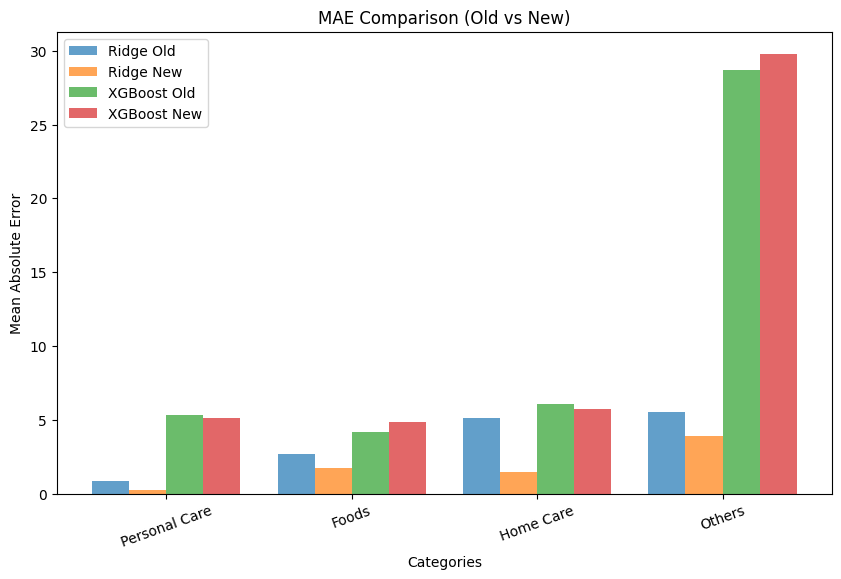

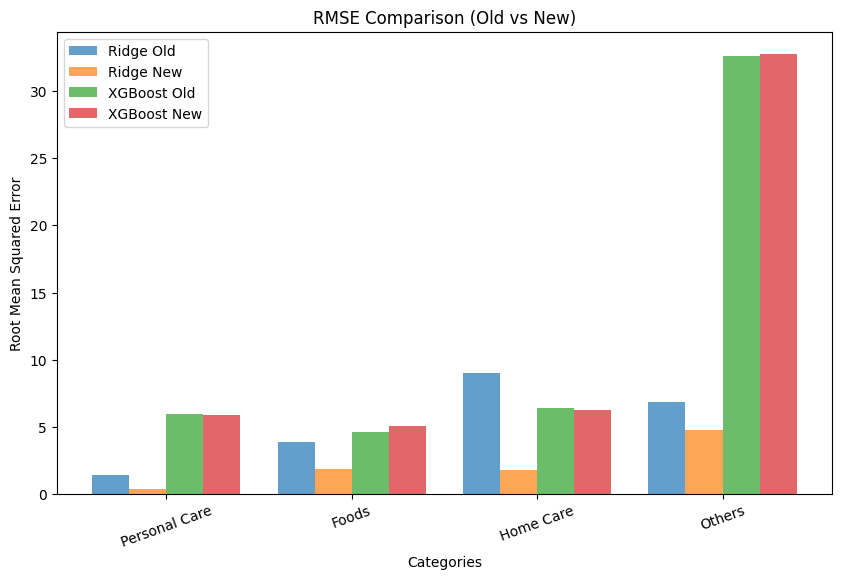

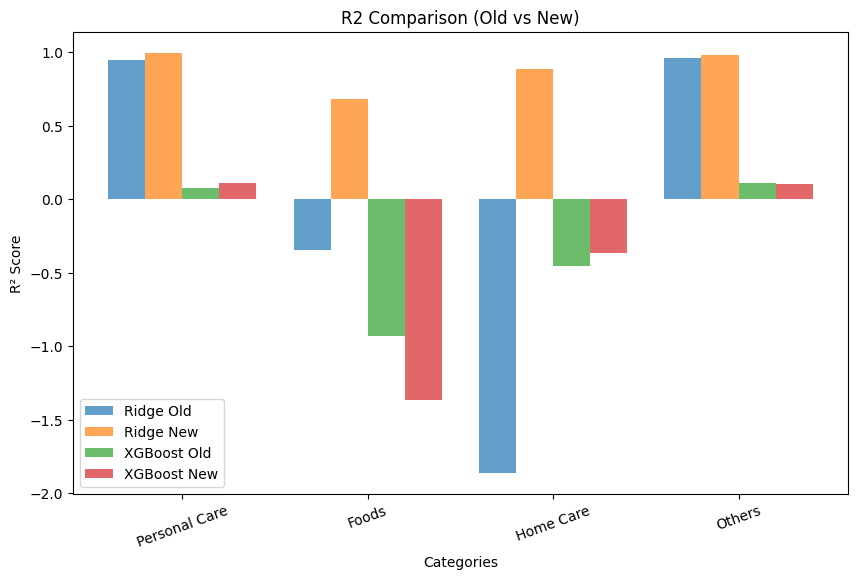

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Categories
categories = ["Personal Care", "Foods", "Home Care", "Others"]

# Old results
ridge_old = {
    "MAE": [0.87, 2.71, 5.11, 5.56],
    "RMSE": [1.40, 3.83, 9.01, 6.84],
    "R2": [0.9496, -0.3430, -1.8614, 0.9609]
}
xgb_old = {
    "MAE": [5.31, 4.16, 6.09, 28.69],
    "RMSE": [5.98, 4.59, 6.42, 32.66],
    "R2": [0.0766, -0.9286, -0.4530, 0.1079]
}

# New results
ridge_new = {
    "MAE": [0.28, 1.74, 1.51, 3.89],
    "RMSE": [0.37, 1.86, 1.77, 4.74],
    "R2": [0.9965, 0.6812, 0.8895, 0.9812]
}
xgb_new = {
    "MAE": [5.13, 4.84, 5.74, 29.79],
    "RMSE": [5.87, 5.08, 6.23, 32.79],
    "R2": [0.1100, -1.3644, -0.3674, 0.1009]
}

# Plot function
def plot_metric(metric, ylabel):
    x = np.arange(len(categories))  # x-axis positions
    width = 0.2

    fig, ax = plt.subplots(figsize=(10,6))

    # Bars
    ax.bar(x - 1.5*width, ridge_old[metric], width, label="Ridge Old", alpha=0.7)
    ax.bar(x - 0.5*width, ridge_new[metric], width, label="Ridge New", alpha=0.7)
    ax.bar(x + 0.5*width, xgb_old[metric], width, label="XGBoost Old", alpha=0.7)
    ax.bar(x + 1.5*width, xgb_new[metric], width, label="XGBoost New", alpha=0.7)

    # Labels
    ax.set_xlabel("Categories")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{metric} Comparison (Old vs New)")
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=20)
    ax.legend()

    plt.show()

# Plot all three metrics
plot_metric("MAE", "Mean Absolute Error")
plot_metric("RMSE", "Root Mean Squared Error")
plot_metric("R2", "R² Score")


In [24]:
# Run this cell to collect metrics and produce the three plots + summary tables
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# --- load & feature prep (same as yours) ---
df = pd.read_csv("final_df_gt.csv")
if "Row Labels" in df.columns:
    df.rename(columns={"Row Labels": "Quarter"}, inplace=True)
df["Quarter"] = pd.PeriodIndex(df["Quarter"], freq="Q-DEC")
df.set_index("Quarter", inplace=True)
df.dropna(subset=["CPI", "CSI", "FEI"], inplace=True)

segments = ["Personal Care", "Foods", "Home Care", "Others"]
macro_features = ["CPI", "CSI", "FEI"]

for seg in segments:
    gt_col = f"{seg}_GoogleTrends"
    if gt_col in df.columns:
        df[f"{gt_col}_lag1"] = df[gt_col].shift(1)
    vol = f"{seg} Volume Index"
    chain = f"{seg} Chain Volume Index"
    yoy = f"{seg} YoY %"
    df[f"{vol}_lag1"]   = df[vol].shift(1)
    df[f"{vol}_delta"]  = df[vol] - df[vol].shift(1)
    df[f"{chain}_lag1"] = df[chain].shift(1)
    df[f"{yoy}_lag1"]   = df[yoy].shift(1)

df.dropna(inplace=True)

# --- rolling evaluation: capture metrics and predictions ---
rolling_windows = [3,5,7,9]
records = []   # metrics
pred_store = []  # store predictions for plotting (window, seg, y_true, y_ridge, y_xgb)

for window in rolling_windows:
    for seg in segments:
        vol = f"{seg} Volume Index"
        chain = f"{seg} Chain Volume Index"
        yoy   = f"{seg} YoY %"
        gt_lag = f"{seg}_GoogleTrends_lag1"
        features = [f"{vol}_lag1", f"{vol}_delta", f"{chain}_lag1", f"{yoy}_lag1"]
        if gt_lag in df.columns:
            features.append(gt_lag)
        features += [c for c in macro_features if c in df.columns]
        df_seg = df[features + [vol]].copy()
        n = len(df_seg)
        y_true_all, y_ridge_all, y_xgb_all = [], [], []

        for i in range(n - window):
            train = df_seg.iloc[: i + window]
            test  = df_seg.iloc[i + window : i + window + 1]
            X_train = train[features]; y_train = train[vol]
            X_test  = test[features]; y_test  = test[vol].values[0]
            # Ridge
            scaler = StandardScaler()
            X_tr_s = scaler.fit_transform(X_train)
            X_te_s = scaler.transform(X_test)
            ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])
            ridge.fit(X_tr_s, y_train)
            y_r = ridge.predict(X_te_s)[0]
            # XGB
            xgb = XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, verbosity=0)
            xgb.fit(X_train, y_train)
            y_x = xgb.predict(X_test)[0]

            y_true_all.append(y_test); y_ridge_all.append(y_r); y_xgb_all.append(y_x)

        # metrics
        if len(y_true_all) > 0:
            for model_name, preds in [("Ridge", y_ridge_all), ("XGB", y_xgb_all)]:
                mae = mean_absolute_error(y_true_all, preds)
                rmse = np.sqrt(mean_squared_error(y_true_all, preds))
                r2 = r2_score(y_true_all, preds)
                records.append({
                    "window": window,
                    "segment": seg,
                    "model": model_name,
                    "MAE": mae,
                    "RMSE": rmse,
                    "R2": r2,
                    "n_test": len(y_true_all)
                })
            pred_store.append({
                "window": window, "segment": seg,
                "y_true": np.array(y_true_all),
                "y_ridge": np.array(y_ridge_all),
                "y_xgb": np.array(y_xgb_all)
            })

metrics_df = pd.DataFrame(records)
metrics_df.to_csv("rolling_metrics_summary.csv", index=False)
print("Saved metrics to rolling_metrics_summary.csv")


Saved metrics to rolling_metrics_summary.csv


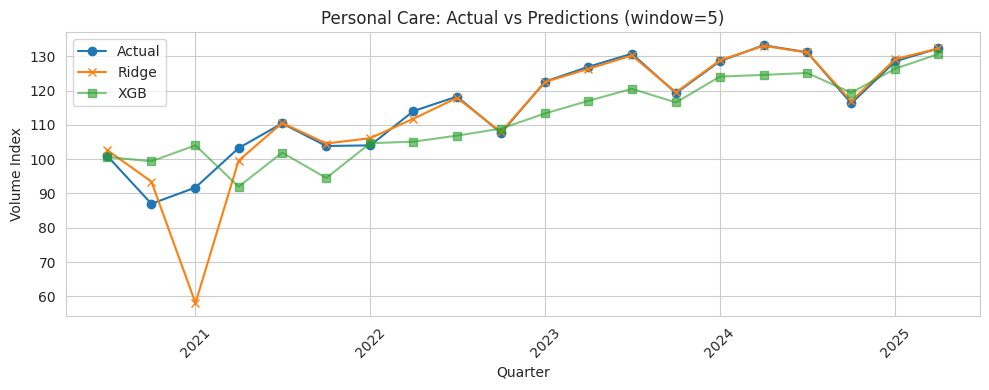

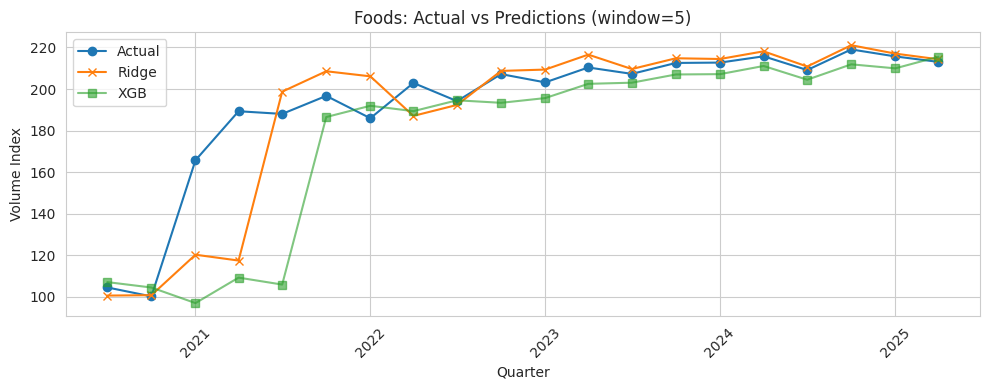

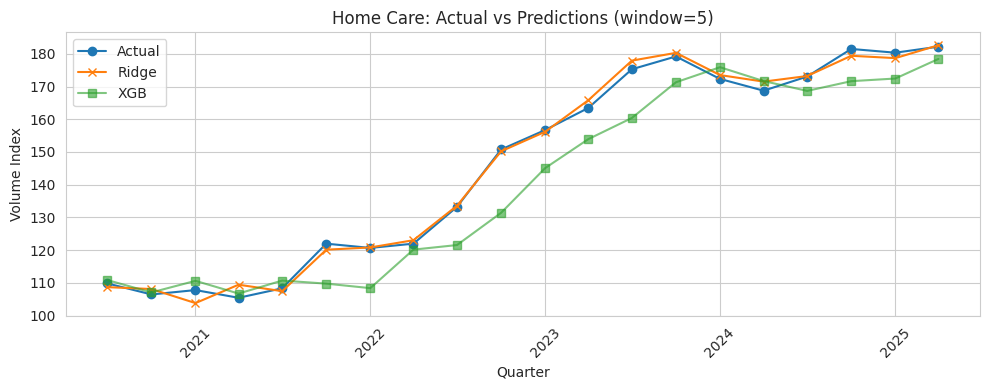

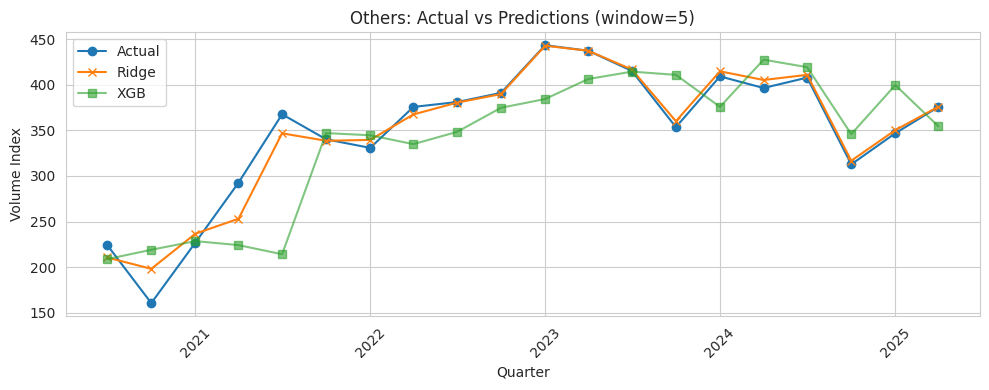

In [25]:
import matplotlib.dates as mdates

window_choice = 5

for seg_choice in segments:
    ps = [p for p in pred_store if p["window"]==window_choice and p["segment"]==seg_choice]
    if len(ps)==1:
        p = ps[0]

        # Build corresponding dates for test points
        df_seg = df[[f"{seg_choice} Volume Index"]].dropna()
        n = len(df_seg)
        test_quarters = df_seg.index[window_choice:]  # PeriodIndex
        test_quarters = test_quarters.to_timestamp()  # convert to datetime

        if len(test_quarters) != len(p["y_true"]):
            print(f"⚠ Length mismatch for {seg_choice}, skipping")
            continue

        # Plot
        plt.figure(figsize=(10,4))
        plt.plot(test_quarters, p["y_true"], marker='o', label='Actual')
        plt.plot(test_quarters, p["y_ridge"], marker='x', label='Ridge')
        plt.plot(test_quarters, p["y_xgb"], marker='s', label='XGB', alpha=0.6)

        plt.title(f"{seg_choice}: Actual vs Predictions (window={window_choice})")
        plt.xlabel("Quarter")
        plt.ylabel("Volume Index")
        plt.legend()

        # Format x-axis: yearly ticks
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # year-quarter

        plt.xticks(rotation=45)
        plt.tight_layout()

        fname = f"plot_pred_vs_actual_{seg_choice.lower().replace(' ','')}_w{window_choice}.png"
        plt.savefig(fname, dpi=150)
        plt.show()
    else:
        print(f"No preds found for {seg_choice} @ window={window_choice}")


## Financial Analysis

In [26]:
import pandas as pd
import numpy as np

def process_company(bs_path, pl_path, name):
    # Read CSVs (adjust skiprows if your files actually have extra header rows)
    bs = pd.read_excel(bs_path, skiprows=[1])
    pl = pd.read_excel(pl_path, skiprows=[1])

    # Reshape so years become rows
    bs = bs.set_index(bs.columns[0]).T.reset_index().rename(columns={"index": "Year"})
    pl = pl.set_index(pl.columns[0]).T.reset_index().rename(columns={"index": "Year"})

    # Robust numeric cleaning
    def clean_numeric(df):
        df = df.copy()
        for col in df.columns:
            if col == "Year":
                continue
            s = df[col].astype(str).str.strip()

            # Remove commas from all values
            s = s.str.replace(",", "", regex=False)

            # Convert lone dashes or empty strings (missing data) to NaN,
            # but preserve negative numbers like "-1234"
            s = s.replace(r'^\s*[-–—]\s*$', np.nan, regex=True)
            s = s.replace(r'^\s*$', np.nan, regex=True)

            # Finally coerce to numeric (safe)
            df[col] = pd.to_numeric(s, errors="coerce")

        return df

    bs = clean_numeric(bs)
    pl = clean_numeric(pl)

    # Helper to safely pull columns (returns series of NaNs if not present)
    def safe_col(df, name_variants):
        for n in name_variants:
            if n in df.columns:
                return df[n]
        return pd.Series(np.nan, index=df.index)

    # Common column name variants - adjust if your files use different exact names
    revenue = safe_col(pl, ["Revenue From Operations [Net]", "Revenue From Operations", "Total Revenue", "Revenue"])
    cost_of_materials = safe_col(pl, ["Cost Of Materials Consumed", "Cost of materials consumed"])
    purchase_stock = safe_col(pl, ["Purchase Of Stock-In Trade", "Purchase Of Stock-in-Trade", "Purchase Of Stock In Trade"])
    change_in_inv = safe_col(pl, ["Changes In Inventories Of FGWIP And Stock In Trade",
                                  "Change in inventories", "Changes In Inventories"])

    # Derive COGS - note: whether you add or subtract `change_in_inv` depends on sign/convention in your P&L.
    # Most Indian P&Ls show "Change in inventories" so that adding it is correct (it may be positive or negative).
    COGS = cost_of_materials.fillna(0) + purchase_stock.fillna(0) + change_in_inv.fillna(0)

    # Balance sheet items (use safe names)
    inventory = safe_col(bs, ["Inventories", "Inventory"])
    receivables = safe_col(bs, ["Trade Receivables", "Receivables"])
    payables = safe_col(bs, ["Trade Payables", "Payables"])
    total_assets = safe_col(bs, ["Total Assets"])
    current_assets = safe_col(bs, ["Total Current Assets", "Current Assets", "Total Current Assets"])
    current_liabilities = safe_col(bs, ["Total Current Liabilities", "Current Liabilities"])
    tangible = safe_col(bs, ["Tangible Assets", "Property, Plant and Equipment", "Fixed Assets"])
    intangible = safe_col(bs, ["Intangible Assets", "Intangible"])

    fixed_assets = tangible.fillna(0) + intangible.fillna(0)

    df = pd.DataFrame({
        "Year": bs["Year"],
        "Company": name,
        "Revenue": revenue,
        "COGS": COGS,
        "Inventory": inventory,
        "Trade_Receivables": receivables,
        "Trade_Payables": payables,
        "Total_Assets": total_assets,
        "Current_Assets": current_assets,
        "Current_Liabilities": current_liabilities,
        "Fixed_Assets": fixed_assets,
    })

    # Ensure numeric dtype for calculations
    numeric_cols = ["Revenue","COGS","Inventory","Trade_Receivables","Trade_Payables",
                    "Total_Assets","Current_Assets","Current_Liabilities","Fixed_Assets"]
    df[numeric_cols] = df[numeric_cols].astype(float)

    # ---- RATIOS / DERIVED METRICS ----
    # Average inventory: explicit (Prev_close + Current_close) / 2
    df["Avg_Inventory"] = (df["Inventory"] + df["Inventory"].shift(1)) / 2
    # Explicit Average Inventory
    df.loc[0, "Avg_Inventory"] = df.loc[0, "Inventory"]



    # Inventory Turnover
    df["Inventory_Turnover"] = df["COGS"] / df["Avg_Inventory"]

    # Days Inventory outstanding (avoid divide-by-zero)
    df["Days_Inventory"] = np.where(df["COGS"] != 0,
                                    (df["Avg_Inventory"] / df["COGS"]) * 365,
                                    np.nan)

    # Days Sales Outstanding
    df["DSO"] = np.where(df["Revenue"] != 0,
                         (df["Trade_Receivables"] / df["Revenue"]) * 365,
                         np.nan)

    # Days Payables Outstanding - note: some analysts prefer to use Purchases rather than COGS.
    df["DPO"] = np.where(df["COGS"] != 0,
                         (df["Trade_Payables"] / df["COGS"]) * 365,
                         np.nan)

    # Cash Conversion Cycle
    df["CCC"] = df["DSO"] + df["Days_Inventory"] - df["DPO"]

    # Other turnovers (guard against division by zero)
    df["Asset_Turnover"] = np.where(df["Total_Assets"] != 0, df["Revenue"] / df["Total_Assets"], np.nan)
    df["Working_Capital"] = df["Current_Assets"] - df["Current_Liabilities"]
    df["Working_Capital_Turnover"] = np.where(df["Working_Capital"] != 0, df["Revenue"] / df["Working_Capital"], np.nan)
    df["Fixed_Asset_Turnover"] = np.where(df["Fixed_Assets"] != 0, df["Revenue"] / df["Fixed_Assets"], np.nan)

    # Replace infinities with NaN (in case you get division by zero)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df

companies = {
    "HUL": ("BS HUL.xlsx", "PL HUL.xlsx"),
    "Dabur": ("BS Dabur.xlsx", "PL Dabur.xlsx"),
    "ITC": ("BS ITC.xlsx", "PL ITC.xlsx"),
    "Marico": ("BS Marico.xlsx", "PL Marico.xlsx"),
    "Britannia": ("BS brit.xlsx", "PL brit.xlsx"),
}


dfs = []
for name, (bs_path, pl_path) in companies.items():
    dfs.append(process_company(bs_path, pl_path, name))

all_company_df = pd.concat(dfs, ignore_index=True)
all_company_df["Year"] = (
    all_company_df["Year"]
    .astype(str)
    .str.strip()
    .str.replace("-", " ", regex=False)   # unify '-' and ' '
    .str.replace(r"\s+", " ", regex=True) # collapse multiple spaces
)

In [27]:
all_company_df["Year"] = pd.to_datetime(all_company_df["Year"], errors="coerce").dt.strftime("%b %d")
print(all_company_df[["Inventory_Turnover", "Company", "Year", "Days_Inventory"]])


    Inventory_Turnover    Company    Year  Days_Inventory
0             6.925934        HUL  Mar 25       52.700471
1             7.054640        HUL  Mar 24       51.738995
2             7.667352        HUL  Mar 23       47.604443
3             6.166287        HUL  Mar 22       59.192831
4             5.771466        HUL  Mar 21       63.242166
5             5.754491        HUL  Mar 20       63.428720
6             6.917806        HUL  Mar 19       52.762396
7             6.577551        HUL  Mar 18       55.491781
8             6.455481        HUL  Mar 17       56.541102
9             6.025062        HUL  Mar 16       60.580292
10            2.841108      Dabur  Mar 25      128.471023
11            3.035949      Dabur  Mar 24      120.225982
12            3.157090      Dabur  Mar 23      115.612805
13            2.866009      Dabur  Mar 22      127.354788
14            2.618962      Dabur  Mar 21      139.368175
15            2.788375      Dabur  Mar 20      130.900637
16            

In [28]:
# Ratios we want to average
core_ratio_cols = [
    "Inventory_Turnover", "Days_Inventory", "DSO", "DPO", "CCC",
    "Asset_Turnover", "Working_Capital_Turnover", "Fixed_Asset_Turnover"
]

# 1) Normalize Year
all_company_df["Year"] = all_company_df["Year"].astype(str).str.strip()

# 2) Keep only core ratios
final_core = all_company_df[["Year", "Company"] + core_ratio_cols].copy()

# 3) HUL only
hul_core = final_core[final_core["Company"] == "HUL"].copy()
valid_years = hul_core["Year"].unique().tolist()

# 4) Industry Avg (exclude HUL, only HUL years)
industry_avg = (
    final_core[final_core["Company"] != "HUL"]
    .groupby("Year", as_index=False)[core_ratio_cols]
    .mean()
)
industry_avg = industry_avg[industry_avg["Year"].isin(valid_years)].copy()
industry_avg["Company"] = "Industry Avg"

# 5) Reorder each separately
hul_core["Year"] = pd.Categorical(hul_core["Year"], categories=valid_years, ordered=True)
industry_avg["Year"] = pd.Categorical(industry_avg["Year"], categories=valid_years, ordered=True)

hul_core = hul_core.sort_values("Year").reset_index(drop=True)
industry_avg = industry_avg.sort_values("Year").reset_index(drop=True)

# 6) Final concat
ps3_df = pd.concat([hul_core, industry_avg], ignore_index=True)

# 7) Round
ps3_df[core_ratio_cols] = ps3_df[core_ratio_cols].round(2)

ps3_df


Year       Company  Inventory_Turnover  Days_Inventory    DSO     DPO  \
0   Mar 25           HUL                6.93           52.70  22.38  135.06   
1   Mar 24           HUL                7.05           51.74  17.94  128.61   
2   Mar 23           HUL                7.67           47.60  18.87  110.18   
3   Mar 22           HUL                6.17           59.19  15.83  128.61   
4   Mar 21           HUL                5.77           63.24  13.85  145.06   
5   Mar 20           HUL                5.75           63.43  10.69  150.63   
6   Mar 19           HUL                6.92           52.76  17.13  142.37   
7   Mar 18           HUL                6.58           55.49  13.71  156.43   
8   Mar 17           HUL                6.46           56.54  12.20  138.41   
9   Mar 16           HUL                6.03           60.58  14.66  130.78   
10  Mar 25  Industry Avg                4.45          108.86  25.45   91.33   
11  Mar 24  Industry Avg                4.10          116.85  24.27   96.37   
12  Mar 23  Industry Avg                4.41          103.27  22.06   85.03   
13  Mar 22  Industry Avg                4.03          106.89  17.66   83.87   
14  Mar 21  Industry Avg                3.52          125.36  16.31   96.15   
15  Mar 20  Industry Avg                3.78          126.58  22.74   87.21   
16  Mar 19  Industry Avg                4.19          115.07  26.50   86.64   
17  Mar 18  Industry Avg                3.96          125.75  21.86   91.06   
18  Mar 17  Industry Avg                3.94          128.90  18.79   81.81   
19  Mar 16  Industry Avg                4.23          127.14  19.72   81.89   

      CCC  Asset_Turnover  Working_Capital_Turnover  Fixed_Asset_Turnover  
0  -59.98            0.78                     11.30                  1.69  
1  -58.93            0.78                      7.22                  1.68  
2  -43.70            0.81                     11.98                  1.69  
3  -53.59            0.73                     12.15                  1.51  
4  -67.96            0.67                     14.88                  1.36  
5  -76.51            1.95                     13.06                  7.32  
6  -72.48            2.08                     11.91                  8.41  
7  -87.23            1.95                     12.58                  7.84  
8  -69.67            2.07                     13.21                  7.48  
9  -55.53            2.13                      9.60                  9.90  
10  42.98            1.22                     17.89                  4.74  
11  44.75            1.17                      9.34                  4.40  
12  40.30            1.19                     13.42                  4.93  
13  40.67            1.29                    -13.67                  6.25  
14  45.52            1.15                      7.30                  5.73  
15  62.11            1.12                      5.21                  5.45  
16  54.93            1.23                      5.69                  5.96  
17  56.56            1.25                      5.34                  6.38  
18  65.88            1.39                      6.23                  6.51  
19  64.97            1.51                      9.72                  7.19

In [29]:
latest = hul_core["Year"].iloc[0]   # your ordering already puts latest first
peers_latest = final_core[(final_core["Year"]==latest) & (final_core["Company"]!="HUL")]
print("Peers (latest):\n", peers_latest.set_index("Company")[core_ratio_cols])

mean_ind = peers_latest[core_ratio_cols].mean().rename("Mean_Industry")
median_ind = peers_latest[core_ratio_cols].median().rename("Median_Industry")
print("\nMean vs Median (latest):\n", pd.concat([mean_ind, median_ind], axis=1))
hul = ps3_df[ps3_df["Company"]=="HUL"].set_index("Year")
ind = ps3_df[ps3_df["Company"]=="Industry Avg"].set_index("Year")

abs_gap = (hul[core_ratio_cols] - ind[core_ratio_cols]).reset_index().assign(Metric="AbsGap")
pct_gap = ((abs_gap[core_ratio_cols].set_index(abs_gap["Year"]) / ind[core_ratio_cols].replace(0,np.nan)) * 100).reset_index().assign(Metric="PctGap")

abs_gap.to_csv("ps3_abs_gap.csv", index=False)
pct_gap.to_csv("ps3_pct_gap.csv", index=False)
print("Saved ps3_abs_gap.csv and ps3_pct_gap.csv")


Peers (latest):
            Inventory_Turnover  Days_Inventory        DSO         DPO  \
Company                                                                
Dabur                2.841108      128.471023  26.153406  157.807375   
ITC                  2.019351      180.751171  23.075726   54.869754   
Marico               4.362753       83.662769  43.223237   92.333890   
Britannia            8.575790       42.561677   9.338036   60.313178   

                  CCC  Asset_Turnover  Working_Capital_Turnover  \
Company                                                           
Dabur       -3.182945        0.763911                  5.600677   
ITC        148.957143        0.847460                  2.525555   
Marico      34.552116        1.287239                  4.093440   
Britannia   -8.413464        1.983925                 59.356239   

           Fixed_Asset_Turnover  
Company                          
Dabur                  3.459245  
ITC                    3.545142  
Marico     

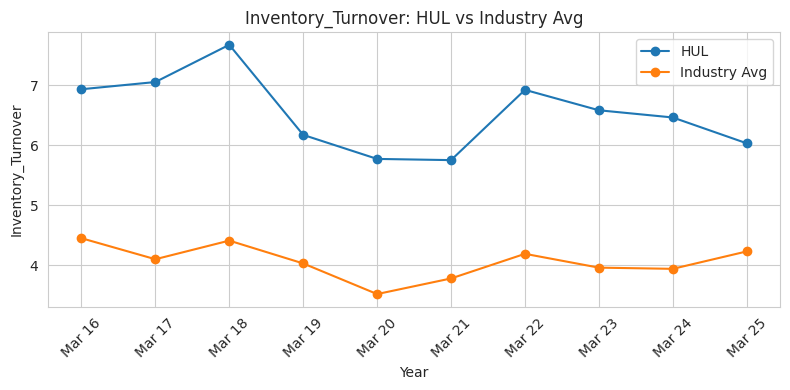

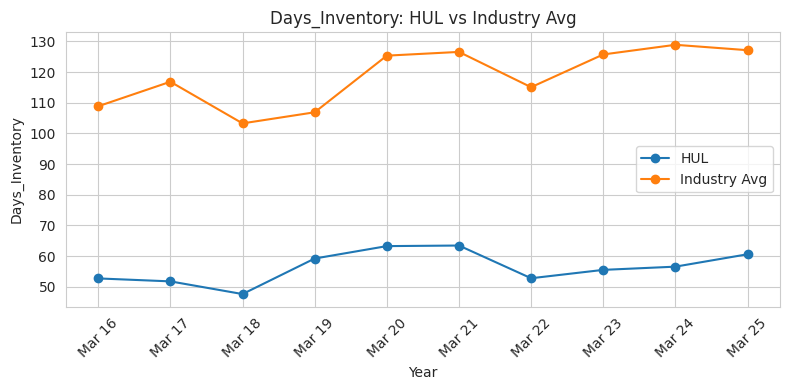

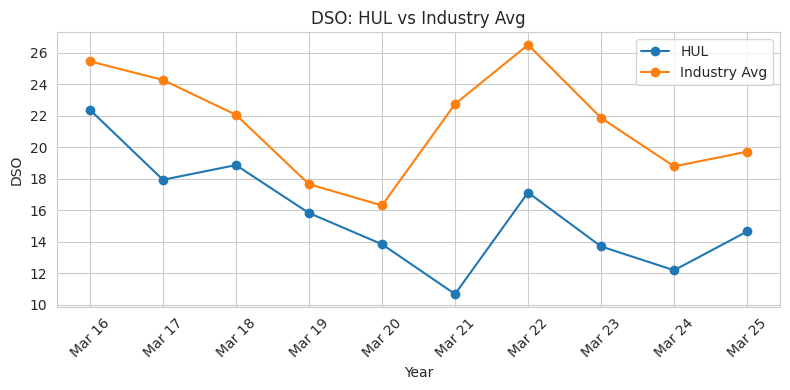

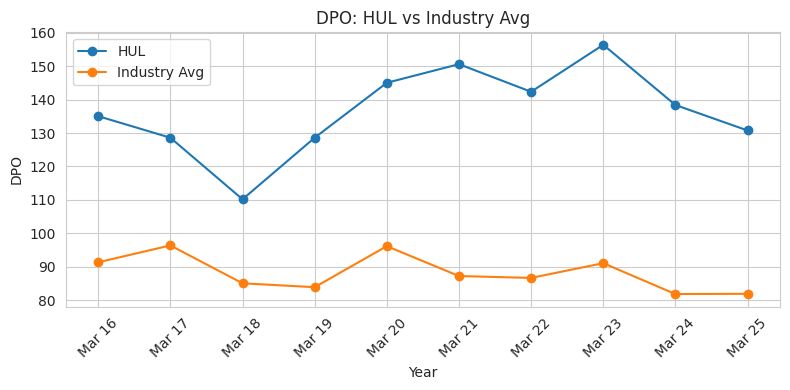

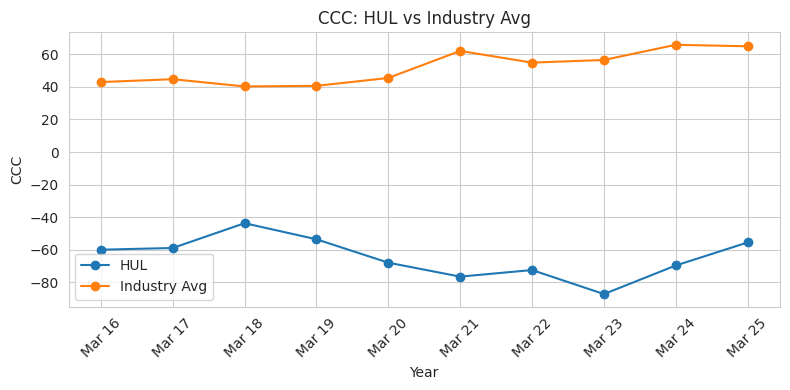

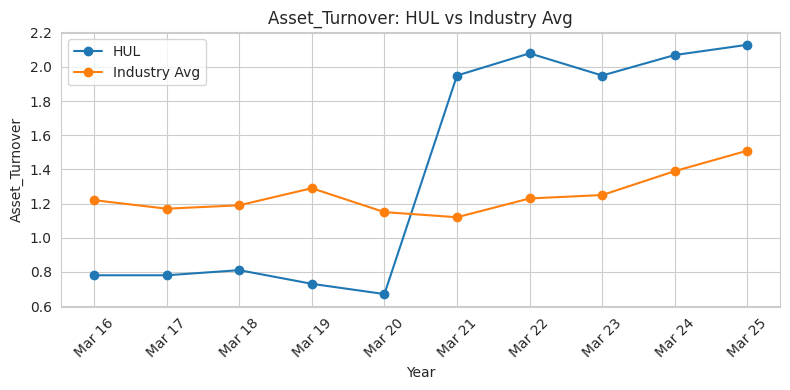

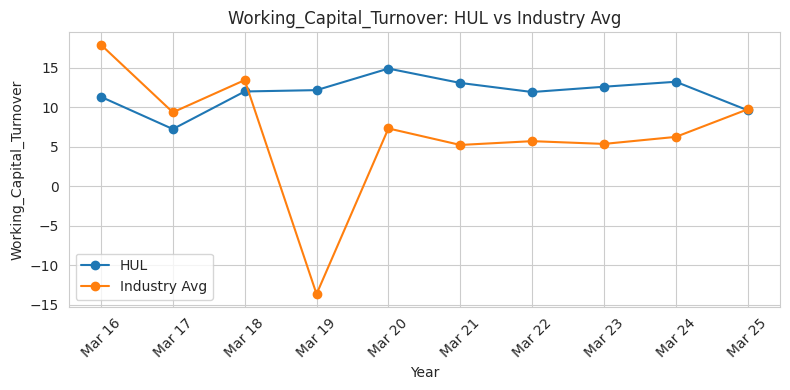

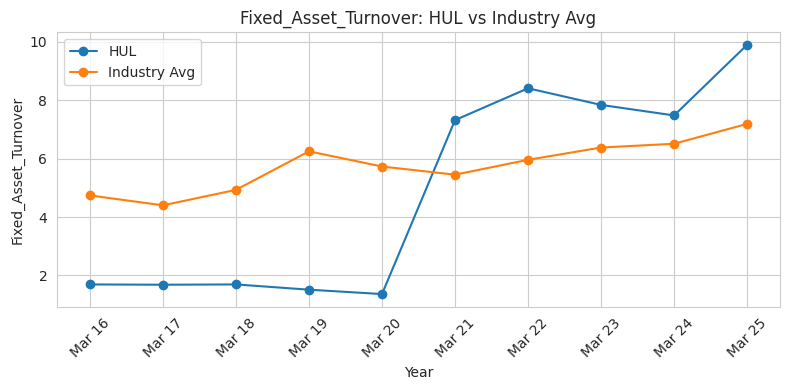

Saved ratio trend plots to ps3_plots/ and displayed inline.


In [30]:
import matplotlib.pyplot as plt, os
os.makedirs("ps3_plots", exist_ok=True)
years = sorted(hul.index.tolist())  # ensures 2019 → 2025 order

for col in core_ratio_cols:
    plt.figure(figsize=(8,4))
    plt.plot(years, hul[col], marker='o', label='HUL')
    plt.plot(years, ind[col], marker='o', label='Industry Avg')
    plt.title(f"{col}: HUL vs Industry Avg")
    plt.xlabel("Year")
    plt.ylabel(col)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # save first, then display inline
    savepath = f"ps3_plots/{col}_hul_vs_ind.png"
    plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()   # <-- this prints the figure inline in Colab
    plt.close()

print("Saved ratio trend plots to ps3_plots/ and displayed inline.")
